# Reproducing experimental results

## 0. Common settings

In [1]:
from utils.util import load_dataset
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.animation as animation
import numpy as np

In [2]:
gpu = 0
vehicle_speed = 41.0
wait_time = 0.5
max_batch_size = 12800
eval_batch_size = 128
eval_size = 100
epoch = 26

## 1. Generating synthetic datasets

In [1]:
!python generate_dataset.py --save_dir data/syn_ev12_n50 --num_samples 1280000 1000 100
!python generate_dataset.py --save_dir data/syn_ev12_n25 --num_samples 1280000 1000 100 --num_locs 25
!python generate_dataset.py --save_dir data/syn_ev6_n50  --num_samples 1280000 1000 100 --num_vehicles 6

## 2. Training models

In [ ]:
num_ev_loc_list = [(12, 50), (12, 25), (6, 50)]
for num_evs, num_locs in num_ev_loc_list:
    dataset_path = f"data/syn_ev{num_evs}_n{num_locs}/train_dataset.pkl"
    model_checkpoint_path = f"checkpoints/weight100_ev{num_evs}_12h_n{num_locs}_drop2"
    !python train.py --dataset_path {dataset_path} \
                     --model_checkpoint_path {model_checkpoint_path} \
                     --batch_size 256 \
                     --baseline rollout \
                     --vehicle_speed {vehicle_speed} \
                     --wait_time {wait_time} \
                     --time_horizon 12 \
                     --epoch {epoch}
                     --gpu {gpu}

selected device: GPU #0


## 3. Model selection

In [3]:
import os
# model_dataset_dirs = [
#     ("checkpoints/weight100_ev12_12h_n50_drop2", "data/syn_ev12_n50"),
#     ("checkpoints/weight100_ev12_12h_n25_drop2", "data/syn_ev12_n25"),
#     ("checkpoints/weight100_ev6_12h_n50_drop2", "data/syn_ev6_n50")
#     ("checkpoints/syn_small_test", "data/syn_ev6_n50")
# ]
model_dataset_dirs = [
    ("checkpoints/fixed_weight100_ev12_12h_n50_drop2", "data/ffixed_final_ev12_n50"),
    ("checkpoints/fixed_weight100_ev12_12h_n25_drop2", "data/ffixed_final_ev12_n25"),
    ("checkpoints/fixed_weight100_ev6_12h_n50_drop2",  "data/ffixed_final_ev6_n50")
]
for model_dir, dataset_dir in model_dataset_dirs:
    dataset_path = f"{dataset_dir}/valid_dataset.pkl"
    !python valid.py --model_dir {model_dir} \
                     --dataset_path {dataset_path} \
                     --eval_batch_size 256 \
                     --vehicle_speed {vehicle_speed} \
                     --wait_time {wait_time} \
                     --time_horizon 12 \
                     --max_epoch {epoch} \
                     --gpu {gpu}

selected device: GPU #0
Evaluating the model at epoch0 (currently best epoch is 0: cost=1000000000.0)
selected device: GPU #0
100%|█████████████████████████████████████████████| 4/4 [00:07<00:00,  1.84s/it]
Evaluating the model at epoch1 (currently best epoch is 0: cost=30.52468490600586)
selected device: GPU #0
100%|█████████████████████████████████████████████| 4/4 [00:05<00:00,  1.43s/it]
Evaluating the model at epoch2 (currently best epoch is 1: cost=23.706758499145508)
selected device: GPU #0
100%|█████████████████████████████████████████████| 4/4 [00:04<00:00,  1.11s/it]
Evaluating the model at epoch3 (currently best epoch is 2: cost=20.84492301940918)
selected device: GPU #0
100%|█████████████████████████████████████████████| 4/4 [00:04<00:00,  1.17s/it]
Evaluating the model at epoch4 (currently best epoch is 3: cost=18.456005096435547)
selected device: GPU #0
100%|█████████████████████████████████████████████| 4/4 [00:04<00:00,  1.21s/it]
Evaluating the model at epoch5 (current

## 4. Quantitative evaluation

### 4.0. Common settings

In [4]:
import pandas as pd
import json
def eval_all(model_list, dataset_list, timehorizon_list, visualize_routes=False):
    for dataset_name, dataset_path, model_dir in dataset_list:
        for time_horizon in timehorizon_list:
            print(f"{dataset_name} T={time_horizon}")
            for model_name, model_type, decode_type, search_width in model_list:
                print(model_type, decode_type, search_width)
                output_dir = f"results/{dataset_name}_T{time_horizon}_evaluation/{model_name}"
                log_fname  = f"{output_dir}/summary.json"
                !python eval.py --gpu {gpu} \
                                --dataset_path {dataset_path} \
                                --vehicle_speed {vehicle_speed} \
                                --wait_time {wait_time} \
                                --time_horizon {time_horizon} \
                                --model_type {model_type} \
                                --decode_type {decode_type} \
                                --search_width {search_width} \
                                --max_batch_size {max_batch_size} \
                                --model_dir {model_dir} \
                                --eval_batch_size {eval_batch_size} \
                                --max_load_size {eval_size} \
                                --log_fname {log_fname} \
                                --visualize_routes \
                                --output_dir {output_dir}

def summarize_results(model_list, dataset_list, timehorizon_list):
    idx = []; col1 = []; col2 = []; results = [[] for _ in range(len(model_list))]
    for i, (model_name, model_type, decode_type, search_width) in enumerate(model_list):
        idx.append(model_name)
        for dataset_name, dataset_path, model_dir in dataset_list:
            for time_horizon in timehorizon_list:
                if i == 0:
                    for eval_values in ["len.", "down", "obj", "time"]:
                        col1.append(f"{dataset_name}_T{time_horizon}")
                        col2.append(eval_values)
                # read a log file
                log_fname = f"results/{dataset_name}_T{time_horizon}_evaluation/{model_name}/summary.json"
                with open(log_fname, "r") as f:
                    res = json.load(f)
                    results[i].append(round(float(res["avg_actual_tour_length"])))    # (actual) route length
                    results[i].append(round(float(res["avg_num_down"]), 2)) # num down locs
                    results[i].append(round(float(res["avg_obj"]), 2)) # objevtive value
                    results[i].append(round(float(res["total_calc_time"]), 2)) # total calc time
    col = pd.MultiIndex.from_arrays([col1, col2])
    return pd.DataFrame(results, index=idx, columns=col)

In [5]:
model_list = [
    ("wo_move", "wo_move", None, 1), 
    ("greedy", "naive_greedy", None, 1),
    ("random", "naive_random", None, 12800), 
    ("rlgreedy", "rl", "greedy", 1), 
    ("rlsample1280", "rl", "sampling", 1280), 
    ("rlsample12800", "rl", "sampling", 12800)
]
timehorizon_list = [12, 24]

### 4.1. Evaluation on synthetic datasets

In [9]:
# syn_dataset_list = [
#     ("SYN-EV6", "data/syn_ev6_n50/eval_dataset.pkl", "checkpoints/weight100_ev6_12h_n50_drop2"),
#     ("SYN-EV12", "data/syn_ev12_n50/eval_dataset.pkl", "checkpoints/weight100_ev12_12h_n50_drop2")
# ]
syn_dataset_list = [
    ("SYN-EV6", "data/ffixed_final_ev6_n50/eval_dataset.pkl", "checkpoints/fixed_weight100_ev6_12h_n50_drop2"),
    ("SYN-EV12", "data/ffixed_final_ev12_n50/eval_dataset.pkl", "checkpoints/fixed_weight100_ev12_12h_n50_drop2")
]

In [10]:
eval_all(model_list, syn_dataset_list, timehorizon_list)

SYN-EV6 T=12
wo_move None 1
selected device: GPU #0
100%|█████████████████████████████████████████████| 1/1 [00:04<00:00,  4.89s/it]
naive_greedy None 1
selected device: GPU #0
100%|█████████████████████████████████████████████| 1/1 [00:04<00:00,  4.46s/it]
naive_random None 12800
selected device: GPU #0
100%|█████████████████████████████████████████████| 1/1 [01:29<00:00, 89.25s/it]
rl greedy 1
selected device: GPU #0
100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.36s/it]
rl sampling 1280
selected device: GPU #0
100%|█████████████████████████████████████████████| 1/1 [00:42<00:00, 42.23s/it]
rl sampling 12800
selected device: GPU #0
100%|████████████████████████████████████████████| 1/1 [06:33<00:00, 393.45s/it]
SYN-EV6 T=24
wo_move None 1
selected device: GPU #0
100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.91s/it]
naive_greedy None 1
selected device: GPU #0
100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.4

In [11]:
summarize_results(model_list, syn_dataset_list, timehorizon_list)

SYN-EV6_T12                       SYN-EV6_T24                \
                     len.   down    obj    time        len.   down    obj   
wo_move                 0  20.08  40.15    2.96           0  33.27  66.55   
greedy                184  17.76  37.36    2.36         315  30.02  63.20   
random                144  15.48  32.40   87.28         264  26.91  56.45   
rlgreedy               84  12.71  26.27    1.29         133  25.61  52.56   
rlsample1280           80  12.50  25.80   40.05         134  24.91  51.16   
rlsample12800          80  12.46  25.72  391.35         132  24.77  50.86   

                      SYN-EV12_T12                       SYN-EV12_T24         \
                 time         len.   down    obj    time         len.   down   
wo_move          3.38            0  20.06  40.13    3.08            0  33.31   
greedy           2.80          184  15.63  33.11    3.74          310  27.19   
random         159.07          158  12.11  25.81  221.23          286  21.95   
rlgreedy         1.94           82   6.96  14.74    1.78          133  18.39   
rlsample1280    71.98           78   6.68  14.15   70.73          135  17.55   
rlsample12800  709.22           78   6.63  14.03  697.44          135  17.40   

                               
                 obj     time  
wo_move        66.62     4.69  
greedy         57.48     4.42  
random         46.76   373.79  
rlgreedy       38.12     2.66  
rlsample1280   36.45   127.55  
rlsample12800  36.15  1272.70

### 4.2. Evaluation on real datasets (only private)

In [13]:
# real_dataset_list = [
#     ("REAL-EV6", "data/final_real_datasets/final_real_ev6/real_ev6.pkl", "checkpoints/weight100_ev6_12h_n50_drop2"),
#     ("REAL-EV12", "data/final_real_datasets/final_real_ev12/real_ev12.pkl", "checkpoints/weight100_ev12_12h_n50_drop2")
# ]

real_dataset_list = [
    ("REAL-EV6", "data/final_real_datasets/final_real_ev6/real_ev6.pkl", "checkpoints/fixed_weight100_ev6_12h_n50_drop2"),
    ("REAL-EV12", "data/final_real_datasets/final_real_ev12/real_ev12_mod.pkl", "checkpoints/fixed_weight100_ev12_12h_n50_drop2")
]

In [14]:
eval_all(model_list, real_dataset_list, timehorizon_list, visualize_routes=True)

REAL-EV6 T=12
wo_move None 1
selected device: GPU #0
100%|█████████████████████████████████████████████| 1/1 [00:04<00:00,  4.81s/it]
naive_greedy None 1
selected device: GPU #0
100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.85s/it]
naive_random None 12800
selected device: GPU #0
100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.03s/it]
rl greedy 1
selected device: GPU #0
100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.04s/it]
rl sampling 1280
selected device: GPU #0
100%|█████████████████████████████████████████████| 1/1 [00:04<00:00,  4.47s/it]
rl sampling 12800
selected device: GPU #0
100%|█████████████████████████████████████████████| 1/1 [00:11<00:00, 11.08s/it]
REAL-EV6 T=24
wo_move None 1
selected device: GPU #0
100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.86s/it]
naive_greedy None 1
selected device: GPU #0
100%|█████████████████████████████████████████████| 1/1 [00:04<00:00,  4

In [57]:
# evaluate CP4TSN
dt_list = [
    ("tsn1", 1.0, None, None),
    ("tsn05", 0.5, None, None)
]
real_dataset_list = [
    ("REAL-EV6", "data/final_real_datasets/final_real_ev6/real_ev6_wo_smalldepots_mod.pkl", None),
    # ("REAL-EV12", "data/final_real_datasets/final_real_ev12_wo_smalldepots/real_ev12_wo_smalldepots_mod.pkl", None)
]
for dataset_name, dataset_path, model_dir in real_dataset_list:
    for time_horizon in timehorizon_list:
        print(f"{dataset_name} T={time_horizon}")
        for model_name, dt, _, __ in dt_list:
            print(model_name)
            output_dir = f"results/{dataset_name}_T{time_horizon}_evaluation/{model_name}"
            log_fname  = f"{output_dir}/summary.json"
            !python eval_cp4tsn.py --dataset_path {dataset_path} \
                                   --clustering \
                                   --cluster_type kmeans \
                                   --time_horizon {time_horizon} \
                                   --parallel \
                                   --num_cpus 12 \
                                   --limit_type time \
                                   --time_limit  1800 \
                                   --dt {dt} \
                                   --log_fname {log_fname}

REAL-EV6 T=12
tsn1
  0%|                                                     | 0/1 [00:00<?, ?it/s]The original problem was split into 6 sub-problem(s)!
defining a model...done
defining a model...done
defining a model...done
defining a model...done
defining a model...done
defining a model...done
The optimal solution found!!!
The optimal solution found!!!
The optimal solution found!!!
The optimal solution found!!!
The optimal solution found!!!
The optimal solution found!!!
100%|█████████████████████████████████████████████| 1/1 [00:32<00:00, 32.38s/it]
tsn05
  0%|                                                     | 0/1 [00:00<?, ?it/s]The original problem was split into 6 sub-problem(s)!
defining a model...done
defining a model...done
defining a model...done
defining a model...done
defining a model...done
defining a model...done
The optimal solution found!!!
The optimal solution found!!!
The optimal solution found!!!
The optimal solution found!!!
The optimal solution found!!!
The opti

In [58]:
all_model_list = [
    ("wo_move", "wo_move", None, 1), 
    ("greedy", "naive_greedy", None, 1),
    ("random", "naive_random", None, 12800), 
    ("rlgreedy", "rl", "greedy", 1), 
    ("rlsample1280", "rl", "sampling", 1280),
    ("rlsample12800", "rl", "sampling", 12800),
    ("tsn1", 1.0, None, None),
    ("tsn05", 0.5, None, None)
]
real_dataset_list = [
    ("REAL-EV6", "data/final_real_datasets/final_real_ev6_wo_smalldepots/real_ev6_wo_smalldepots.pkl", None),
    ("REAL-EV12", "data/final_real_datasets/final_real_ev12_wo_smalldepots/real_ev12_wo_smalldepots_mod.pkl", None)
]
summarize_results(all_model_list, real_dataset_list, timehorizon_list)

REAL-EV6_T12                      REAL-EV6_T24                \
                      len.  down    obj    time         len.   down    obj   
wo_move                  0  8.25  24.99    2.94            0  17.52  53.10   
greedy                  24  5.87  19.07    2.07           48  15.49  49.56   
random                  41  3.83  13.81    3.29           61  10.66  35.63   
rlgreedy                14  4.33  13.87    1.19           22  11.69  36.63   
rlsample1280            30  2.51   9.22    2.73           43   8.74  28.84   
rlsample12800           27  2.53   9.11    9.34           42   8.66  28.54   
tsn1                    14  5.77  18.27   32.15           52  12.24  40.07   
tsn05                   18  3.36  11.23  158.14           33  10.24  32.92   

                       REAL-EV12_T12                      REAL-EV12_T24  \
                  time          len.   down    obj   time          len.   
wo_move           3.48             0  11.26  24.48   2.84             0   
greedy            2.45            77   9.34  21.55   2.28           146   
random            4.20           143   5.13  13.44   6.04           212   
rlgreedy          1.78            68   1.65   4.68   1.18           107   
rlsample1280      3.75            70   1.10   3.52   4.28           130   
rlsample12800    15.15            69   1.09   3.48  23.30           116   
tsn1           1800.96            60   4.08   9.83   6.43           113   
tsn05          1801.42            55   2.88   7.15  35.09           134   

                                      
                down    obj     time  
wo_move        25.92  56.35     3.89  
greedy         20.47  46.86     2.68  
random         15.19  36.44     9.15  
rlgreedy       11.59  26.91     1.51  
rlsample1280   11.65  27.42     6.96  
rlsample12800  11.74  27.38    37.71  
tsn1           13.88  32.01   564.88  
tsn05          12.96  30.33  1801.26

## 5. Visualization of routes

In [59]:
def visualize_route(ax, route_data):
    # add base stations & charge stations
    markersize = 8
    loc_coords = np.array(route_data["loc_coords"])
    dep_coords = np.array(route_data["depot_coords"])
    ignored_depots = np.array(route_data["ignored_depots"])
    x_loc = loc_coords[:, 0]; y_loc = loc_coords[:, 1]
    x_dep = dep_coords[:, 0]; y_dep = dep_coords[:, 1]
    ax.scatter(x_loc, y_loc, zorder=2, s=markersize, c="black") # base stations
    ax.scatter(x_dep[~ignored_depots], y_dep[~ignored_depots], marker="s", zorder=2, s=markersize, c="none", ec="red") # charge stations
    
    # add routes
    linewidth = .5
    linestyles = ["solid", "dotted", "dashed", "dashdot", (0, (3, 1, 1, 1, 1, 1)), (5, (10, 3)), (0, (3, 5, 1, 5, 1, 5)), (0, (5, 5)), (0, (3, 5, 1, 5)), (0, (3, 5, 1, 5, 1, 5)), (0, (5, 5)), (0, (3, 5, 1, 5))]
    routes = route_data["route"]
    coords = np.concatenate([loc_coords, dep_coords], axis=0)
    x_coo = coords[:, 0]; y_coo = coords[:, 1]
    num_vehicles = len(routes)
    cmap = plt.get_cmap("tab10")
    additional_colors = ["black", "chartreuse"]
    for veh_id, route in enumerate(routes):
        if veh_id <= 10:
            color = cmap(veh_id)
        else:
            color = additional_colors[veh_id - 11]
        for i in range(len(route)-1):
            curr_id = route[i]
            next_id = route[i+1]
            st = coords[curr_id]
            end = coords[next_id]
            ax.annotate('', xy=end, xytext=st,
                        arrowprops=dict(shrink=0, width=0.5, headwidth=3, 
                        headlength=4, connectionstyle='arc3',
                        facecolor=color, edgecolor='none', alpha=0.5), zorder=1)
        # ax.plot(x_coo[route], y_coo[route], alpha=0.6, zorder=1, c=color, linewidth=linewidth) #, linestyle=linestyles[veh_id])
    ax.set_xticks([]); ax.set_yticks([])

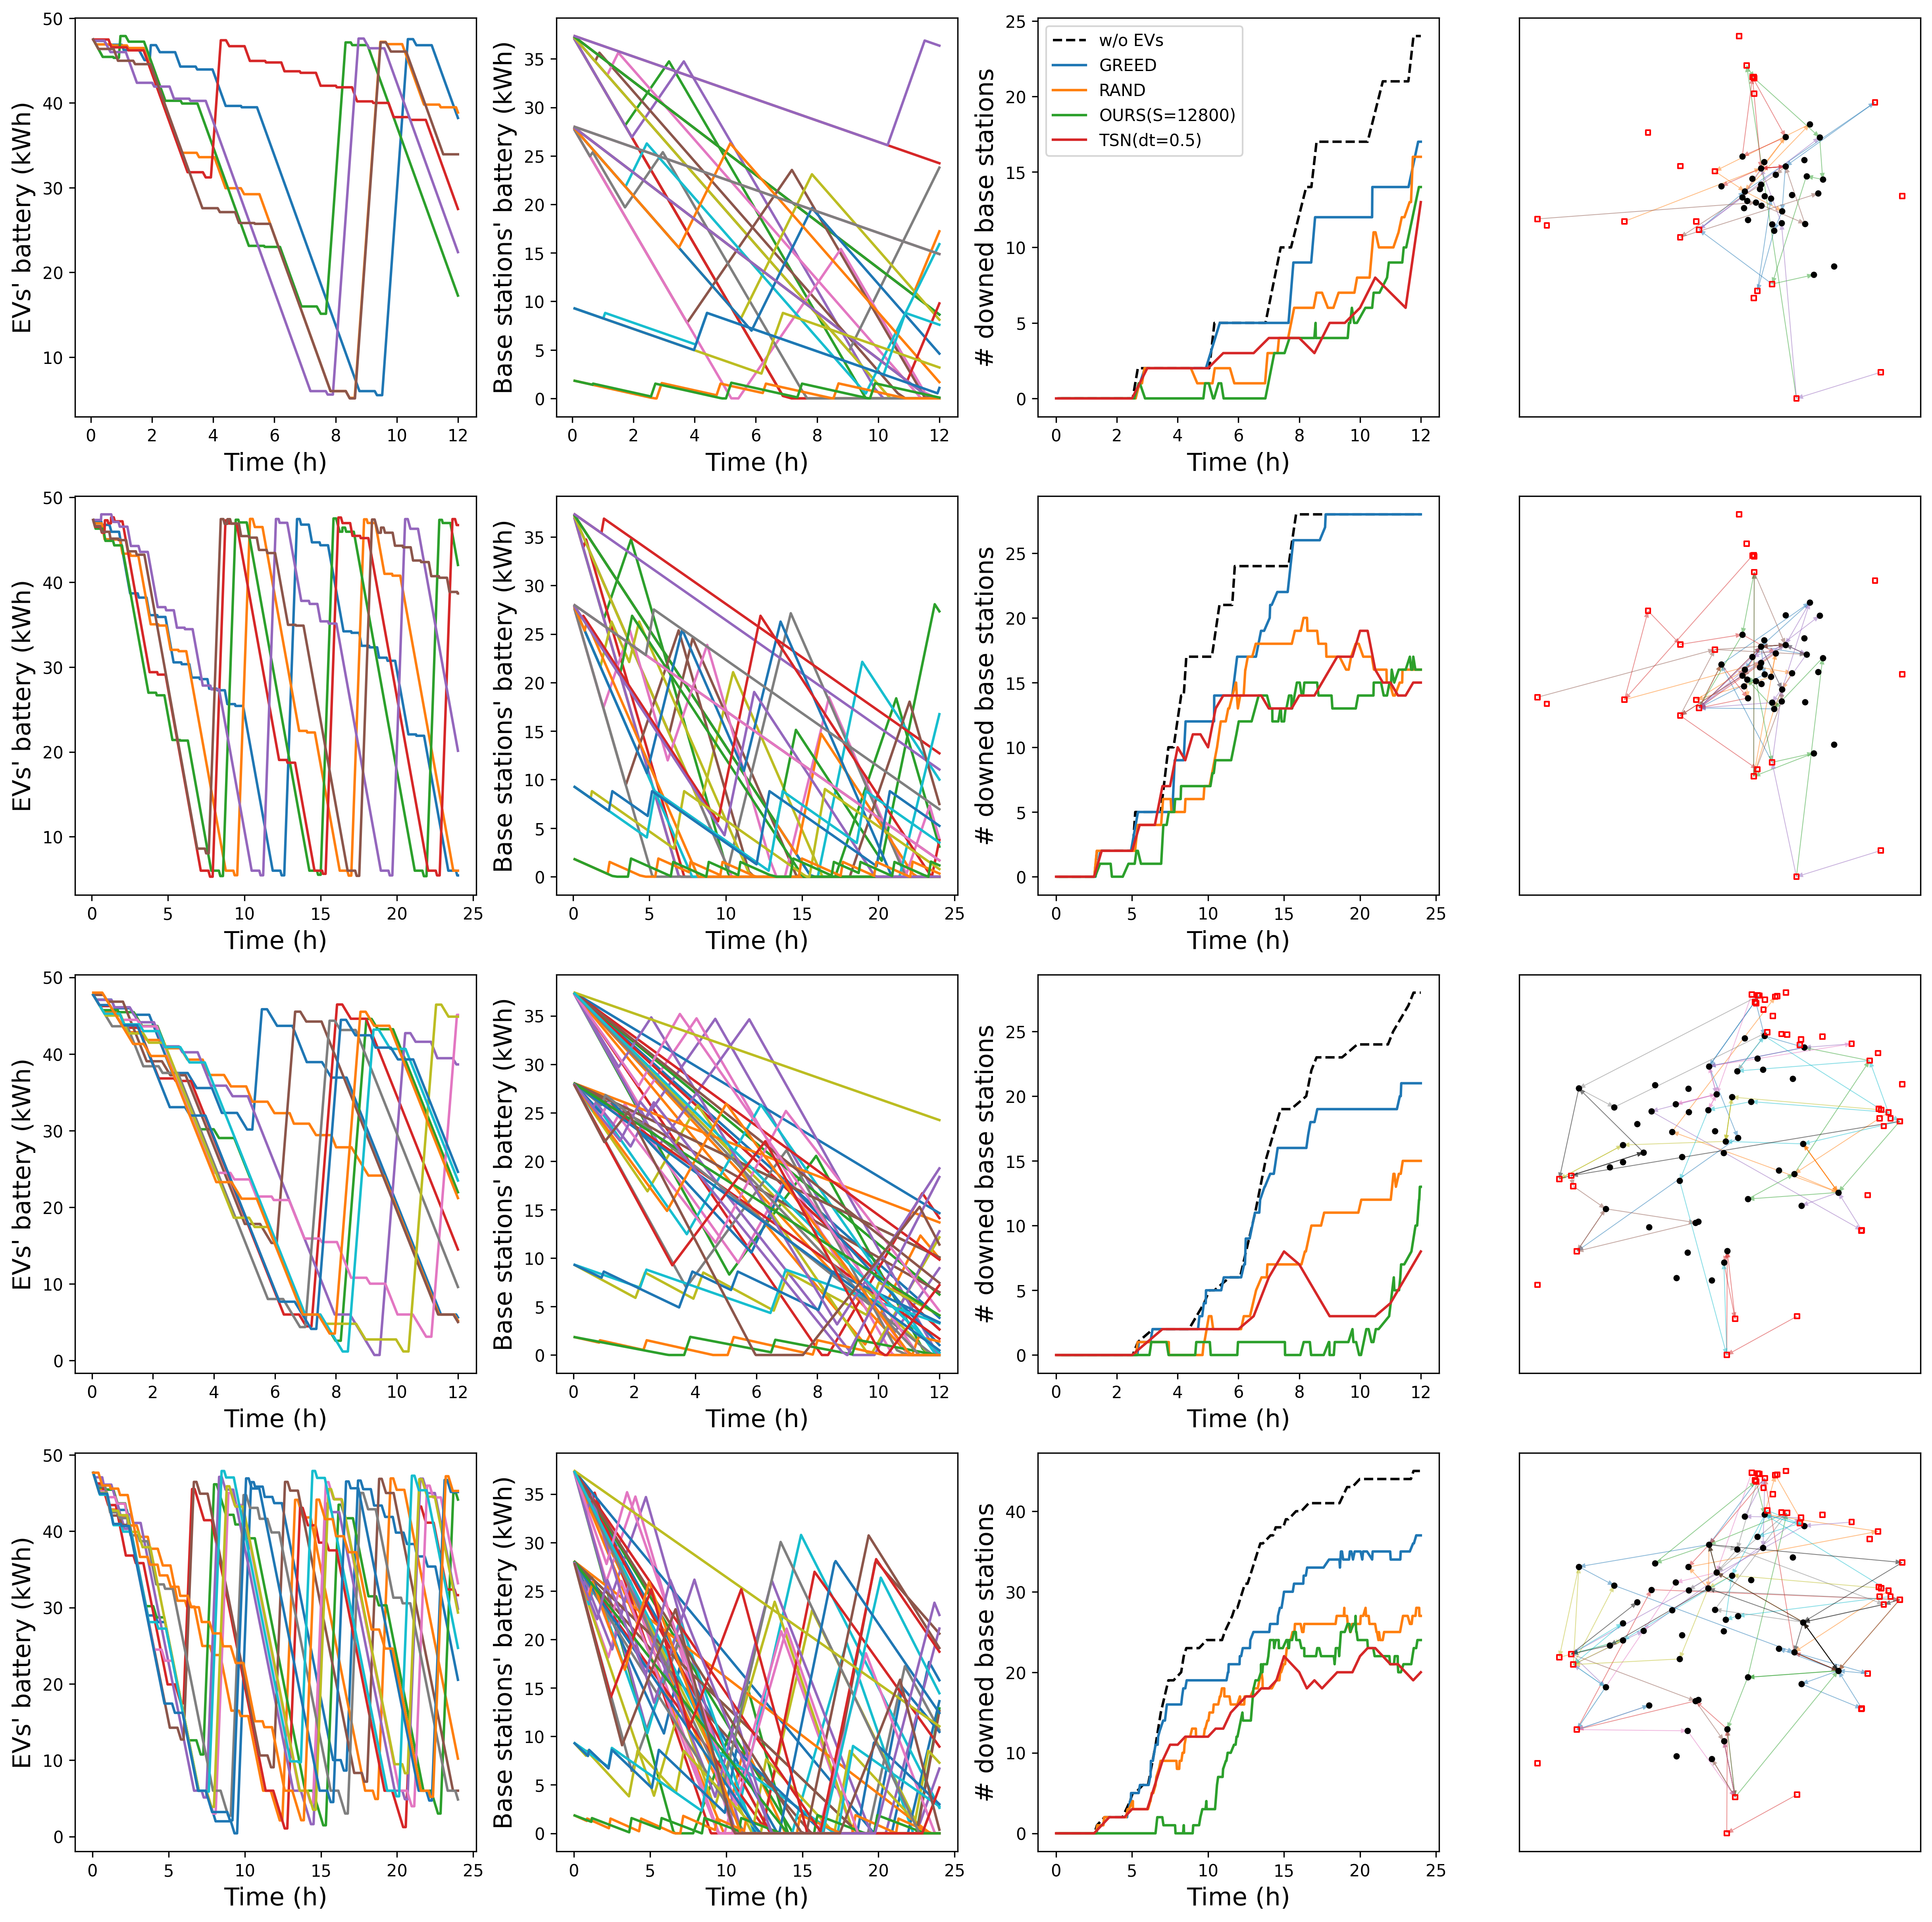

In [60]:
import pickle
DPI = 300
vis_model_list = [
    ("wo_move", "wo_move", None, 1), 
    ("greedy", "naive_greedy", None, 1),
    ("random", "naive_random", None, 12800), 
    ("rlsample12800", "rl", "sampling", 12800),
    # ("tsn1", 1.0, None, None),
    ("tsn05", 0.5, None, None)
]
label = {
    "wo_move": "w/o EVs",
    "greedy": "GREED",
    "random": "RAND",
    "tsn1": "TSN(dt=1)",
    "tsn05": "TSN(dt=0.5)",
    "rlsample12800": "OURS(S=12800)"
}
output_route_model = "rlsample12800"
FONT_SIZE = 15
fig = plt.figure(figsize=(20, 20), dpi=DPI)
ax_dict = {}
for j, (dataset_name, dataset_path, _) in enumerate(real_dataset_list):
    for i, time_horizon in enumerate(timehorizon_list):
        ev_batt_key    = f"{dataset_name}_T{time_horizon}_ev_batt_hist"
        loc_batt_key   = f"{dataset_name}_T{time_horizon}_loc_batt_hist"
        down_hist_key  = f"{dataset_name}_T{time_horizon}_down_hist"
        route_key      = f"{dataset_name}_T{time_horizon}_route"
        ax_dict[ev_batt_key]    = fig.add_subplot(4, 4, 4*(i) + 8*j + 1) # history of EV's battery
        ax_dict[loc_batt_key]   = fig.add_subplot(4, 4, 4*(i) + 8*j + 2) # history of Base station's battery
        ax_dict[down_hist_key]  = fig.add_subplot(4, 4, 4*(i) + 8*j + 3) # history of num. of downed base stations
        ax_dict[route_key]      = fig.add_subplot(4, 4, 4*(i) + 8*j + 4) # route
        for model_name, model_type, decode_type, search_width in vis_model_list:
            res_dir = f"results/{dataset_name}_T{time_horizon}_evaluation/{model_name}/batch0-sample0"
            history_file = f"{res_dir}/history_data.pkl"
            with open(history_file, "rb") as f:
                history_data = pickle.load(f)
                if model_name == "wo_move":
                    ax_dict[down_hist_key].plot(history_data["time"], history_data["down_loc"], label=label[model_name], c="black", linestyle="--")
                else:
                    ax_dict[down_hist_key].plot(history_data["time"], history_data["down_loc"], label=label[model_name])
                ax_dict[down_hist_key].set_xlabel("Time (h)", fontsize=FONT_SIZE)
                ax_dict[down_hist_key].set_ylabel("# downed base stations", fontsize=FONT_SIZE)
                if i + j == 0:
                    ax_dict[down_hist_key].legend()
            if model_name == output_route_model:
                route_file = f"{res_dir}/route_info.pkl"
                with open(route_file, "rb") as f:
                    route_data = pickle.load(f)
                    visualize_route(ax_dict[route_key], route_data)
                with open(history_file, "rb") as f:
                    history_data = pickle.load(f)
                    for veh_id in range(len(history_data["veh_batt"])):
                        ax_dict[ev_batt_key].plot(history_data["time"], history_data["veh_batt"][veh_id])
                        ax_dict[ev_batt_key].set_xlabel("Time (h)", fontsize=FONT_SIZE)
                        ax_dict[ev_batt_key].set_ylabel("EVs' battery (kWh)", fontsize=FONT_SIZE)
                        
                    for loc_id in range(len(history_data["loc_batt"])):
                        ax_dict[loc_batt_key].plot(history_data["time"], history_data["loc_batt"][loc_id])
                        ax_dict[loc_batt_key].set_xlabel("Time (h)", fontsize=FONT_SIZE)
                        ax_dict[loc_batt_key].set_ylabel("Base stations' battery (kWh)", fontsize=FONT_SIZE)

## 6. Scalability test

In [61]:
random_seed = 0
num_samples = 10
gpu = 0
time_horizon_list = [12, 24, 36, 48]
num_loc_list      = [25, 50, 75, 100]
num_ev_list       = [6, 12, 18, 24]

### 6.1. Generating evaluation datasets for scalability test

In [62]:
# for time horizon
!python generate_dataset.py --num_locs 50 --num_vehicles 12 --save_dir data/scalability4time_horizon --type eval --num_samples {num_samples} --random_seed {random_seed}

# for num_locs
for num_locs in num_loc_list:
    !python generate_dataset.py --num_locs {num_locs} --num_vehicles 12 --save_dir data/scalability4num_nodes{num_locs} --type eval --num_samples {num_samples} --random_seed {random_seed}

# for num_evs
for num_evs in num_ev_list:
    !python generate_dataset.py --num_locs 50 --num_vehicles {num_evs} --save_dir data/scalability4num_evs{num_evs} --type eval --num_samples {num_samples} --random_seed {random_seed}

  0%|                                                    | 0/10 [00:00<?, ?it/s]/workspace/app/dev/cirp_for_ev_docomo/generate_dataset.py:99: DeprecationWarning: Seeding based on hashing is deprecated
since Python 3.9 and will be removed in a subsequent version. The only 
supported seed types are: None, int, float, str, bytes, and bytearray.
  random.seed(random_seed)
100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 313.13it/s]
saving a dataset to data/scalability4time_horizon/eval_dataset.pkl...done
  0%|                                                    | 0/10 [00:00<?, ?it/s]/workspace/app/dev/cirp_for_ev_docomo/generate_dataset.py:99: DeprecationWarning: Seeding based on hashing is deprecated
since Python 3.9 and will be removed in a subsequent version. The only 
supported seed types are: None, int, float, str, bytes, and bytearray.
  random.seed(random_seed)
100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 388.68it/s]
saving a dataset to da

### 6.2. Measuring calculation time

In [68]:
# we use a model trained on data with EV=12 N_loc=25 T=12 (Greedy, s=1280, s=12800)
decode_types = [
    ("OURS.G", "greedy", 1),
    ("OURS.S1280", "sampling", 1280),
    ("OURS.S12800", "sampling", 12800)
]
model_dir = "checkpoints/fixed_weight100_ev12_12h_n25_drop2"
def call_eval(dataset_path, time_horizon, decode_type, search_width, log_fname):
    !python eval.py --gpu {gpu} \
                    --dataset_path {dataset_path} \
                    --vehicle_speed 41 \
                    --wait_time 0.5 \
                    --time_horizon {time_horizon} \
                    --model_type rl \
                    --decode_type {decode_type} \
                    --search_width {search_width} \
                    --max_batch_size 12800 \
                    --model_dir {model_dir} \
                    --eval_batch_size 1 \
                    --log_fname {log_fname}

In [69]:
# for time horizon
for decode_name, decode_type, search_width in decode_types:
    print(f"{decode_name}")
    for time_horizon in time_horizon_list:
        print(f"T = {time_horizon}")
        log_fname = f"results/timehorizon_scaletest/{decode_name}_{time_horizon}.json"
        dataset_path = "data/scalability4time_horizon/eval_dataset.pkl"
        call_eval(dataset_path=dataset_path,
                  time_horizon=time_horizon,
                  decode_type=decode_type,
                  search_width=search_width,
                  log_fname=log_fname)

# for num_locs
for decode_name, decode_type, search_width in decode_types:
    print(f"{decode_name}")
    for num_locs in num_loc_list:
        print(f"num_locs = {num_locs}")
        log_fname = f"results/numlocs_scaletest/{decode_name}_{num_locs}.json"
        dataset_path = f"data/scalability4num_nodes{num_locs}/eval_dataset.pkl"
        call_eval(dataset_path=dataset_path,
                  time_horizon=12,
                  decode_type=decode_type,
                  search_width=search_width,
                  log_fname=log_fname)
        
# for num_evs
for decode_name, decode_type, search_width in decode_types:
    print(f"{decode_name}")
    for num_evs in num_ev_list:
        print(f"num_evs = {num_evs}")
        log_fname = f"results/numevs_scaletest/{decode_name}_{num_evs}.json"
        dataset_path = f"data/scalability4num_evs{num_evs}/eval_dataset.pkl"
        call_eval(dataset_path=dataset_path,
                  time_horizon=12,
                  decode_type=decode_type,
                  search_width=search_width,
                  log_fname=log_fname)

OURS.G
T = 12
selected device: GPU #0
100%|███████████████████████████████████████████| 10/10 [00:04<00:00,  2.06it/s]
T = 24
selected device: GPU #0
100%|███████████████████████████████████████████| 10/10 [00:07<00:00,  1.32it/s]
T = 36
selected device: GPU #0
100%|███████████████████████████████████████████| 10/10 [00:10<00:00,  1.07s/it]
T = 48
selected device: GPU #0
100%|███████████████████████████████████████████| 10/10 [00:15<00:00,  1.51s/it]
OURS.S1280
T = 12
selected device: GPU #0
100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.64s/it]
T = 24
selected device: GPU #0
100%|███████████████████████████████████████████| 10/10 [00:30<00:00,  3.07s/it]
T = 36
selected device: GPU #0
100%|███████████████████████████████████████████| 10/10 [00:46<00:00,  4.65s/it]
T = 48
selected device: GPU #0
100%|███████████████████████████████████████████| 10/10 [01:03<00:00,  6.31s/it]
OURS.S12800
T = 12
selected device: GPU #0
100%|██████████████████████████████████████

### 6.3. Plotting a scalability graph

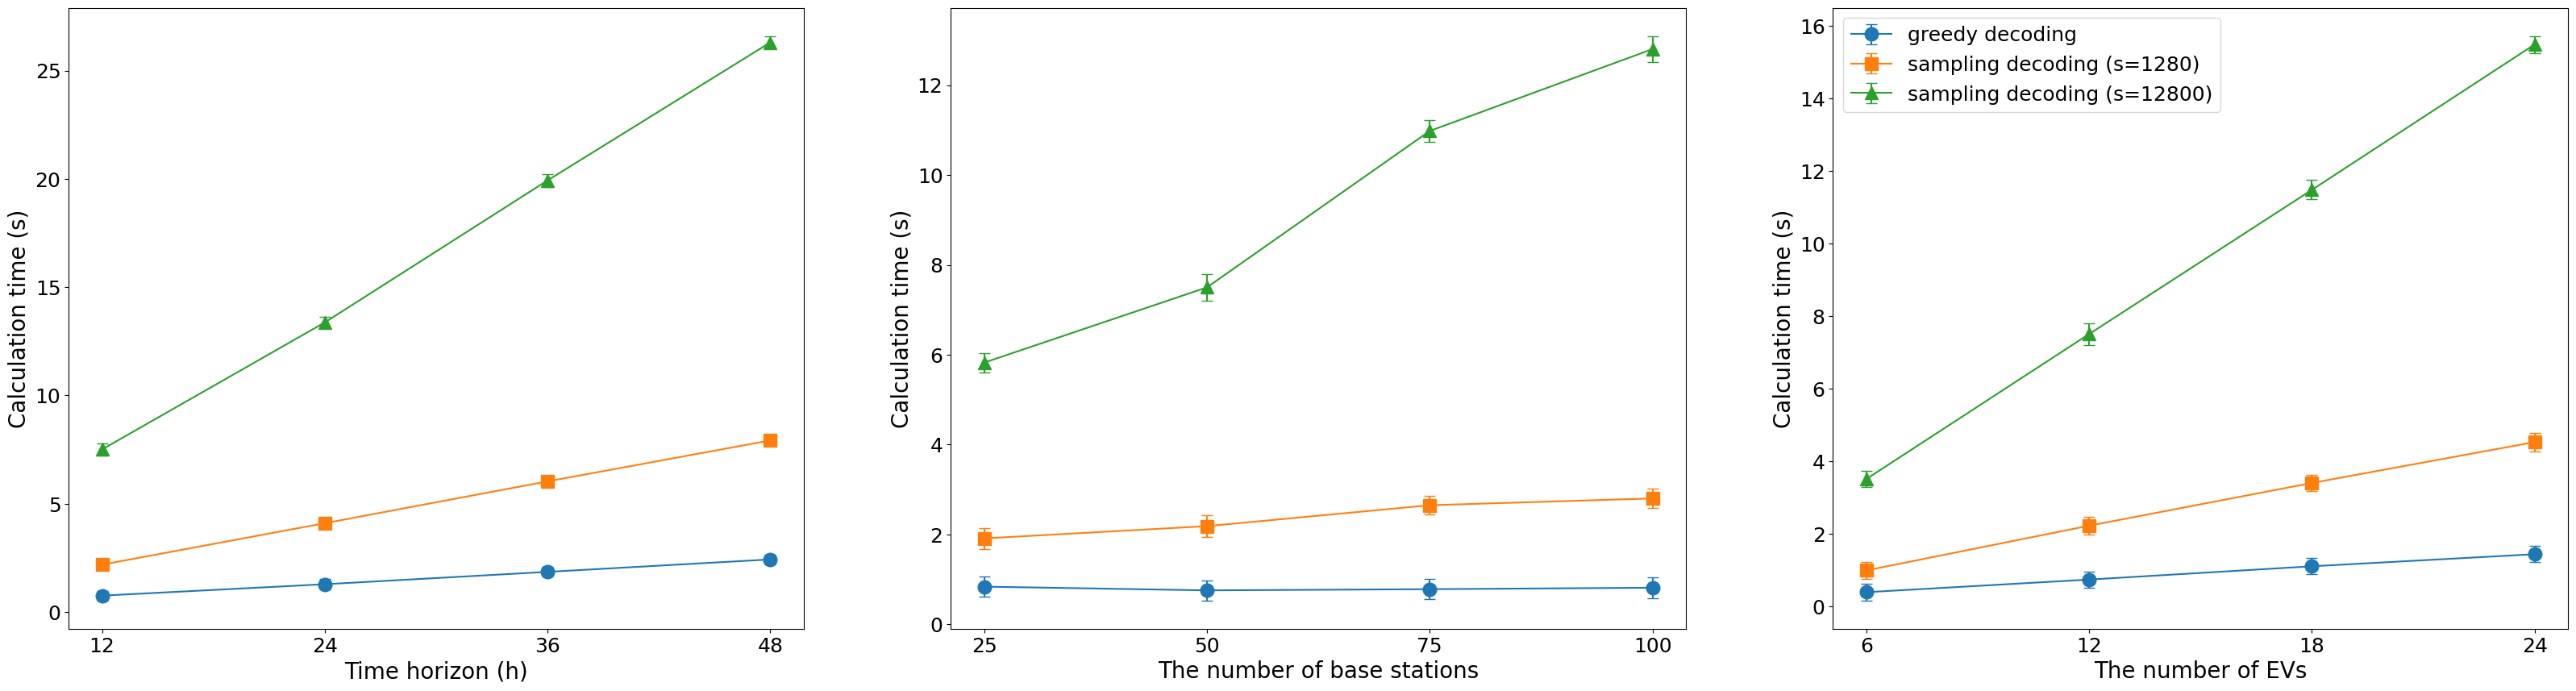

In [8]:
import matplotlib.pyplot as plt

markersize = 12
capsize = 5
fig = plt.figure(figsize=(40, 10))
ax_timehorizon = fig.add_subplot(1, 3, 1)
ax_nlocs = fig.add_subplot(1, 3, 2)
ax_nevs = fig.add_subplot(1, 3, 3)

# scalability for time horizon
for decode_type, search_width in decode_types:
    if decode_type == "greedy":
        label = f"{decode_type} decoding"
        marker = "o"
    else:
        if search_width == 1280:
            marker = "s"
        else:
            marker = "^"
        label = f"{decode_type} decoding (s={search_width})"
    # ax_timehorizon.plot(time_horizon_list, avg_calctime_timehorizon_scaletest[f"{decode_type}{search_width}"], label=label, marker=marker, markersize=markersize)
    ax_timehorizon.errorbar(time_horizon_list, avg_calctime_timehorizon_scaletest[f"{decode_type}{search_width}"], std_calctime_timehorizon_scaletest[f"{decode_type}{search_width}"], label=label, marker=marker, markersize=markersize, capsize=capsize)
    ax_nlocs.errorbar(num_loc_list, avg_calctime_numlocs_scaletest[f"{decode_type}{search_width}"], std_calctime_numlocs_scaletest[f"{decode_type}{search_width}"], label=label, marker=marker, markersize=markersize, capsize=capsize)
    ax_nevs.errorbar(num_ev_list, avg_calctime_numevs_scaletest[f"{decode_type}{search_width}"], std_calctime_numevs_scaletest[f"{decode_type}{search_width}"], label=label, marker=marker, markersize=markersize, capsize=capsize)
ax_timehorizon.set_ylabel("Calculation time (s)", fontsize=20)
ax_timehorizon.set_xlabel("Time horizon (h)", fontsize=20)
ax_timehorizon.set_xticks(time_horizon_list)
ax_timehorizon.xaxis.set_tick_params(labelsize=18)
ax_timehorizon.yaxis.set_tick_params(labelsize=18)
ax_nlocs.set_ylabel("Calculation time (s)", fontsize=20)
ax_nlocs.set_xlabel("The number of base stations", fontsize=20)
ax_nlocs.set_xticks(num_loc_list)
ax_nlocs.xaxis.set_tick_params(labelsize=18)
ax_nlocs.yaxis.set_tick_params(labelsize=18)
ax_nevs.set_ylabel("Calculation time (s)", fontsize=20)
ax_nevs.set_xlabel("The number of EVs", fontsize=20)
ax_nevs.set_xticks(num_ev_list)
ax_nevs.xaxis.set_tick_params(labelsize=18)
ax_nevs.yaxis.set_tick_params(labelsize=18)
plt.legend(fontsize=18)

## 7. Generality test

In [75]:
random_seed = 0
num_samples = 10
gpu = 0
time_horizon_list = [12, 24, 36, 48]
num_loc_list      = [25, 50, 75, 100]
num_ev_list       = [6, 12, 18, 24]

### 7.1. Generating evaluation datasets for generality test

In [76]:
# for time horizon
!python generate_dataset.py --num_locs 50 --num_vehicles 12 --save_dir data/generality4time_horizon --type eval --num_samples {num_samples} --random_seed {random_seed}

# for num_locs
for num_locs in num_loc_list:
    !python generate_dataset.py --num_locs {num_locs} --num_vehicles 12 --save_dir data/generality4num_nodes{num_locs} --type eval --num_samples {num_samples} --random_seed {random_seed}

# for num_evs
for num_evs in num_ev_list:
    !python generate_dataset.py --num_locs 50 --num_vehicles {num_evs} --save_dir data/generality4num_evs{num_evs} --type eval --num_samples {num_samples} --random_seed {random_seed}

  0%|                                                    | 0/10 [00:00<?, ?it/s]/workspace/app/dev/cirp_for_ev_docomo/generate_dataset.py:99: DeprecationWarning: Seeding based on hashing is deprecated
since Python 3.9 and will be removed in a subsequent version. The only 
supported seed types are: None, int, float, str, bytes, and bytearray.
  random.seed(random_seed)
100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 365.19it/s]
saving a dataset to data/generality4time_horizon/eval_dataset.pkl...done
  0%|                                                    | 0/10 [00:00<?, ?it/s]/workspace/app/dev/cirp_for_ev_docomo/generate_dataset.py:99: DeprecationWarning: Seeding based on hashing is deprecated
since Python 3.9 and will be removed in a subsequent version. The only 
supported seed types are: None, int, float, str, bytes, and bytearray.
  random.seed(random_seed)
100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 342.44it/s]
saving a dataset to dat

### 7.2. Measuring objective values

In [77]:
model_list = [
    ("rl", "EV12N50T12", "checkpoints/fixed_weight100_ev12_12h_n50_drop2"), 
    ("rl", "EV12N25T12", "checkpoints/fixed_weight100_ev12_12h_n25_drop2"),
    ("rl", "EV6N50T12", "checkpoints/fixed_weight100_ev6_12h_n50_drop2"),
    ("naive_greedy", "GREED", "greedy"),
    ("naive_random", "RAND", "random")
]

def call_eval(model_type, model_dir, dataset_path, time_horizon, log_fname):
    !python eval.py --gpu {gpu} \
                    --dataset_path {dataset_path} \
                    --vehicle_speed 41 \
                    --wait_time 0.5 \
                    --time_horizon {time_horizon} \
                    --model_type {model_type} \
                    --decode_type sampling \
                    --search_width 12800 \
                    --max_batch_size 12800 \
                    --model_dir {model_dir} \
                    --eval_batch_size 128 \
                    --log_fname {log_fname}

In [78]:
# for time horizon EV12N50T12 v.s. EV12N50T24 v.s. Greedy v.s. Random
model_name_list = ["EV12N50T12", "GREED", "RAND"]
for model_type, model_name, model_dir in model_list:
    if model_name not in model_name_list:
        continue
    print(model_name)
    for time_horizon in time_horizon_list:
        print(f"T={time_horizon}")
        log_fname = f"results/timehorizon_gentest/{model_name}_{time_horizon}.json"
        dataset_path = "data/generality4time_horizon/eval_dataset.pkl"
        call_eval(model_type, model_dir, dataset_path, time_horizon, log_fname)
        
# for num locs
model_name_list = ["EV12N25T12", "EV12N50T12", "GREED", "RAND"]
for model_type, model_name, model_dir in model_list:
    if model_name not in model_name_list:
        continue
    print(model_name)
    for num_locs in num_loc_list:
        print(f"num_locs={num_locs}")
        log_fname = f"results/numlocs_gentest/{model_name}_{num_locs}.res"
        dataset_path = f"data/generality4num_nodes{num_locs}/eval_dataset.pkl"
        call_eval(model_type, model_dir, dataset_path, 12, log_fname)

# for num evs EV12N25T12 v.s. EV12N50T12 v.s. Greedy v.s. Random
model_name_list = ["EV6N50T12", "EV12N50T12", "GREED", "RAND"]
for model_type, model_name, model_dir in model_list:
    if model_name not in model_name_list:
        continue
    print(model_name)
    for num_evs in num_ev_list:
        print(f"num_evs={num_evs}")
        log_fname = f"results/numevs_gentest/{model_name}_{num_evs}.res"
        dataset_path = f"data/generality4num_evs{num_evs}/eval_dataset.pkl"
        call_eval(model_type, model_dir, dataset_path, 12, log_fname)

EV12N50T12
T=12
selected device: GPU #0
100%|█████████████████████████████████████████████| 1/1 [01:05<00:00, 65.33s/it]
T=24
selected device: GPU #0
100%|████████████████████████████████████████████| 1/1 [02:02<00:00, 122.11s/it]
T=36
selected device: GPU #0
100%|████████████████████████████████████████████| 1/1 [02:57<00:00, 177.87s/it]
T=48
selected device: GPU #0
100%|████████████████████████████████████████████| 1/1 [03:51<00:00, 231.57s/it]
GREED
T=12
selected device: GPU #0
100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.66s/it]
T=24
selected device: GPU #0
100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.96s/it]
T=36
selected device: GPU #0
100%|█████████████████████████████████████████████| 1/1 [00:04<00:00,  4.20s/it]
T=48
selected device: GPU #0
100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.01s/it]
RAND
T=12
selected device: GPU #0
100%|█████████████████████████████████████████████| 1/1 [00:24<00:00,

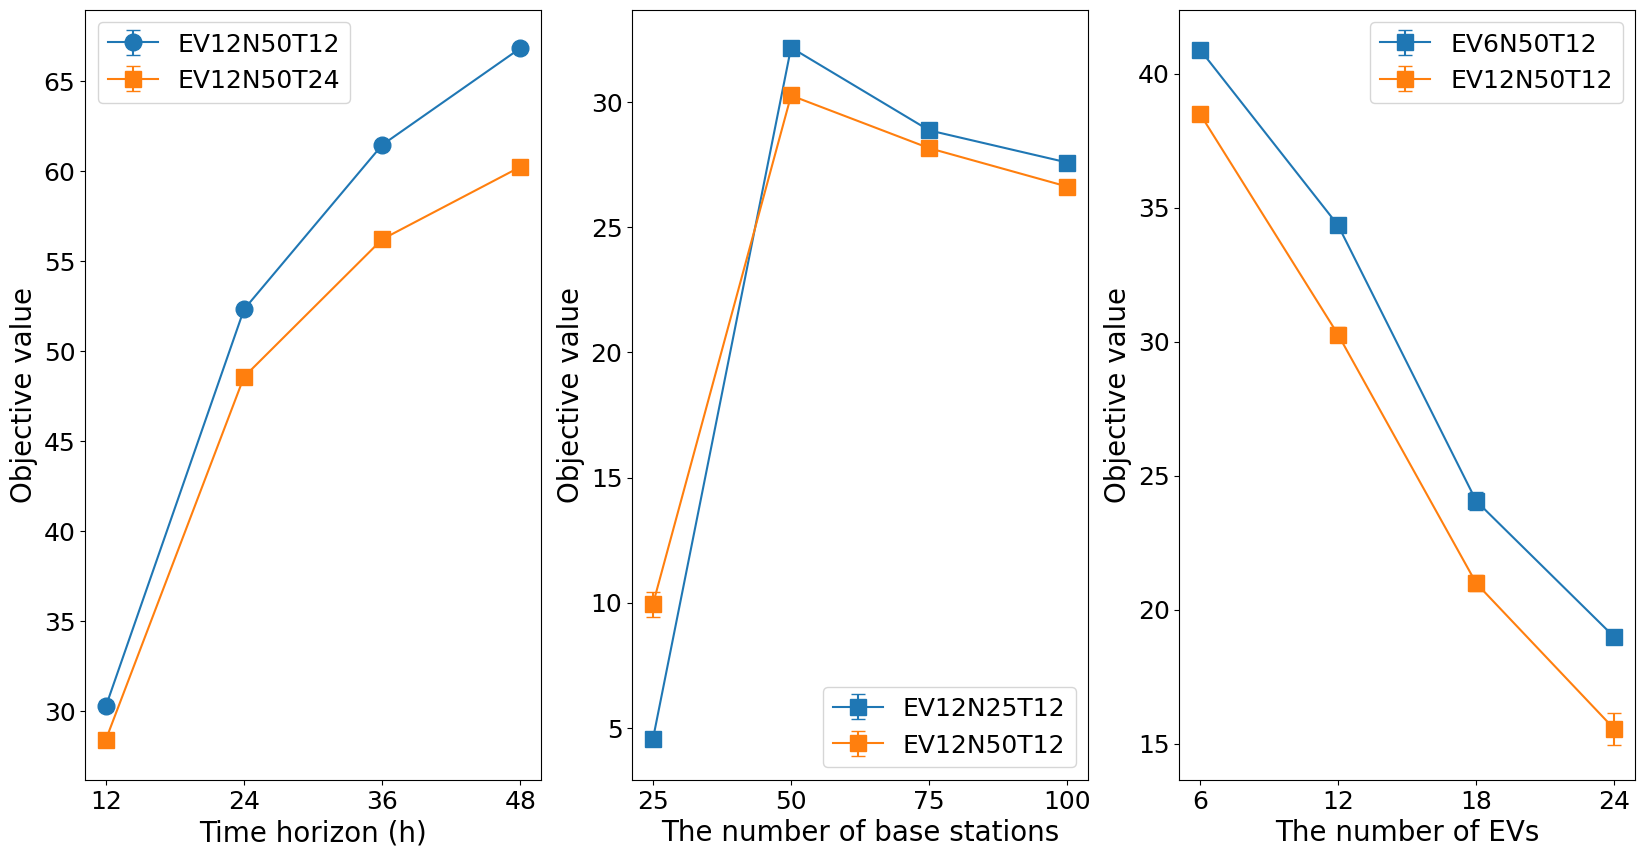

In [20]:
import matplotlib.pyplot as plt

marker_list = ["o", "s", "^", "*"]
markersize = 12
capsize = 5
fig = plt.figure(figsize=(20, 10))
ax_timehorizon = fig.add_subplot(1, 3, 1)
ax_nlocs = fig.add_subplot(1, 3, 2)
ax_nevs = fig.add_subplot(1, 3, 3)

# for timehorizon
model_name_list = ["EV12N50T12", "EV12N50T24"] #, "greedy", "random"]
for i, model_name in enumerate(model_name_list):
    marker = marker_list[i]
    ax_timehorizon.errorbar(time_horizon_list, avg_obj_timehorizon_gentest[model_name], std_obj_timehorizon_gentest[model_name], label=model_name, marker=marker, markersize=markersize, capsize=capsize)
ax_timehorizon.legend(fontsize=18)
ax_timehorizon.set_ylabel("Objective value", fontsize=20)
ax_timehorizon.set_xlabel("Time horizon (h)", fontsize=20)
ax_timehorizon.set_xticks(time_horizon_list)
ax_timehorizon.xaxis.set_tick_params(labelsize=18)
ax_timehorizon.yaxis.set_tick_params(labelsize=18)

# for num_locs
model_list = ["EV12N25T12", "EV12N50T12"] #, "greedy", "random"]
for i, model_name in enumerate(model_list):
    maker = marker_list[i]
    ax_nlocs.errorbar(num_loc_list, avg_obj_numlocs_gentest[model_name], std_obj_numlocs_gentest[model_name], label=model_name, marker=marker, markersize=markersize, capsize=capsize)
ax_nlocs.legend(fontsize=18)
ax_nlocs.set_ylabel("Objective value", fontsize=20)
ax_nlocs.set_xlabel("The number of base stations", fontsize=20)
ax_nlocs.set_xticks(num_loc_list)
ax_nlocs.xaxis.set_tick_params(labelsize=18)
ax_nlocs.yaxis.set_tick_params(labelsize=18)

# for num_evs
model_list = ["EV6N50T12", "EV12N50T12"] # , "greedy", "random"]
for i, model_name in enumerate(model_list):
    maker = marker_list[i]
    ax_nevs.errorbar(num_ev_list, avg_obj_numevs_gentest[model_name], std_obj_numevs_gentest[model_name], label=model_name, marker=marker, markersize=markersize, capsize=capsize)
ax_nevs.legend(fontsize=18)
ax_nevs.set_ylabel("Objective value", fontsize=20)
ax_nevs.set_xlabel("The number of EVs", fontsize=20)
ax_nevs.set_xticks(num_ev_list)
ax_nevs.xaxis.set_tick_params(labelsize=18)
ax_nevs.yaxis.set_tick_params(labelsize=18)

In [ ]:
import torch
from models.tsn.clustered_tsn import KmeansClustering

num_clusters = 4
num_points = 15
x = torch.rand(num_points, 2)
kmeans = KmeansClustering(2, 2)
res = kmeans.balanced_kmeans(x, num_clusters)
print(res)
import matplotlib.pyplot as plt
fig = plt.figure()
x = x.cpu().detach().numpy().copy()
for cluster_id in range(num_clusters):
    idx = (res == cluster_id)
    plt.scatter(x[:, 0][idx], x[:, 1][idx], label=f"{cluster_id}")